In [1]:
import numpy as np
import open3d as o3d
from open3d import JVisualizer
from PIL import Image
import pandas as pd
import plotly.express as px

In [2]:
import selfsupmotion.zero_shot_pose as zsp
zsp.use_cupy = False
experiment = "../output"
embeddings, info_df, train_embeddings, train_info_df = zsp.read_experiment(experiment)


In [3]:
idx=86
#points_2d, points_3d_query = zsp.get_points(info_df, idx)
#points_2d_px_query = zsp.points_2d_to_points2d_px(points_2d, 360, 480)
#plane_center_query, plane_normal_query= zsp.get_plane(info_df, idx)

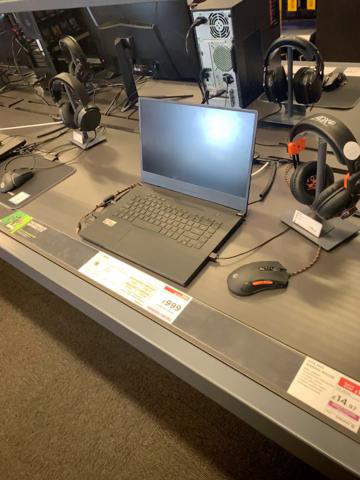

In [4]:
query_im=Image.open(info_df.iloc[idx]["filepath_full"])
query_im

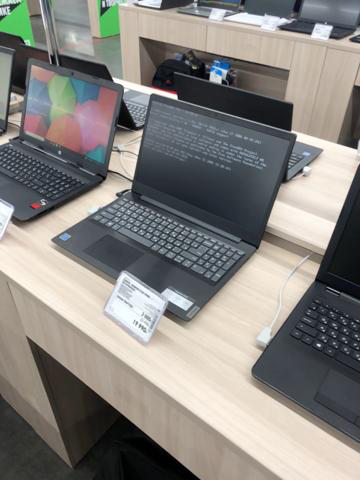

In [5]:
match_idx, score = zsp.find_match_idx(idx, embeddings, train_embeddings,0, score=True)
res_im=Image.open(train_info_df.iloc[match_idx]["filepath_full"])
res_im

In [6]:
match_idx

729598

In [7]:
train_info_df.iloc[match_idx]["filepath_full"], info_df.iloc[idx]["filepath_full"]

('/home/raphael/datasets/objectron/640x480_full/laptop/batch-3_49_0.285.jpg',
 '/home/raphael/datasets/objectron/640x480_full/laptop/batch-23_11_0.250.jpg')

In [8]:

points_3d_result = zsp.get_bounding_box(idx, match_idx, info_df, train_info_df, adjust_scale=True)

0 0.863839679199644
1 0.8596093503594356
2 0.8579535460856907
3 0.8573255845244258


0.8573255845244258


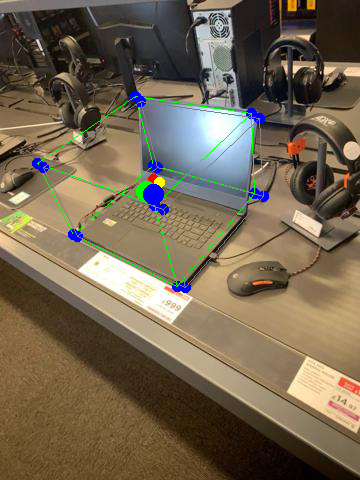

In [9]:
def show_preview(query_idx, points_3d_result):
    query_im=Image.open(info_df.iloc[query_idx]["filepath_full"])
    query_camera = zsp.get_camera(info_df, query_idx)
    query_intrinsics = zsp.get_intrinsics(query_camera)
    points_2d_query, points_3d_query = zsp.get_points(info_df, query_idx)
    points_2d_px_query = zsp.points_2d_to_points2d_px(points_2d_query, 360, 480)
    query_intrinsics = zsp.scale_intrinsics(query_intrinsics, 0.25,0.25)
    points2d_px_result = zsp.project_3d_to_2d(points_3d_result, query_intrinsics)
    points2d_px_query = zsp.project_3d_to_2d(points_3d_query, query_intrinsics)
    print(zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points_3d_result)))
    zsp.draw_bbox(query_im,points2d_px_result)
    zsp.draw_bbox(query_im,points2d_px_query, line_color=(128,128,128), pixel_center_color=(0,0,255),object_center_color=(255,255,0))
    display(query_im)
show_preview(idx, points_3d_result)

In [11]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


slider = widgets.IntSlider(min=0, max=10000, step=1, value=10)

def f(x):
    idx =x 
    match_idx, score = zsp.find_match_idx(idx, embeddings, train_embeddings,0, score=True)
    print(idx, match_idx, score)
    points_3d_result = zsp.get_bounding_box(idx, match_idx, info_df, train_info_df, adjust_scale=True)
    show_preview(idx, points_3d_result)
interact(f, x=slider)


interactive(children=(IntSlider(value=10, description='x', max=10000), Output()), _dom_classes=('widget-intera…

<function __main__.f(x)>

In [234]:
def build_df(points_3d, name="default"):
    df = pd.DataFrame(points_3d).rename(columns={0:"x", 1:"y", 2:"z"})
    df["name"]=name
    df = df.append(pd.Series([0,0,0,"camera"], index=df.columns ), ignore_index=True)
    return df
points3d_df = build_df(points_3d_query, "query")
points3d_df = points3d_df.append(build_df(points_3d_result, "result"))
fig = px.scatter_3d(points3d_df, x="x", y="y", z="z", color="name")
fig.show()
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points_3d_result))

0.43636998013146266

In [40]:
query_camera = zsp.get_camera(info_df, idx)

#result_camera = zsp.get_camera(train_info_df, train_idx)
#result_intrinsics = zsp.get_intrinsics(result_camera)
#result_intrinsics = zsp.scale_intrinsics(result_intrinsics, 0.25, 0.25)

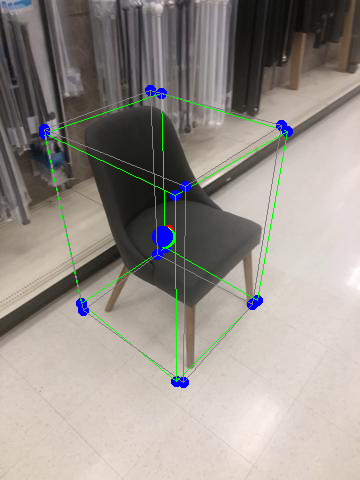

In [19]:
result_bbox = zsp.get_bbox(points2d_px_result, query_im.width, query_im.height)
query_bbox = zsp.get_bbox(points2d_px_query, query_im.width, query_im.height)

In [20]:

scale = zsp.get_bbox_area(query_bbox) / zsp.get_bbox_area(result_bbox)
scale

1.1055183682457537

In [21]:
scale = zsp.get_smooth_scale_factor(points_3d_query, points_3d_result_centered, query_intrinsics, 2)
scale

1.052759184122877

In [22]:
points3d_scaled = zsp.snap_to_plane(zsp.scale_3d_bbox(points_3d_result_centered, scale), plane_normal_query, plane_center_query, center_ray, obj_radius = obj_radius*scale)
points3d_scaled

array([[-0.01861803, -0.04315793, -1.6003138 ],
       [ 0.31463464, -0.44888429, -1.84036112],
       [ 0.55302056, -0.01048551, -1.52644773],
       [-0.33932577, -0.44888345, -1.3437465 ],
       [-0.10094086, -0.01048463, -1.02983313],
       [ 0.06370481, -0.07583126, -2.17079547],
       [ 0.30208973,  0.36256757, -1.85688223],
       [-0.5902556 , -0.07583041, -1.67418085],
       [-0.35187069,  0.36256841, -1.36026761]])

In [23]:
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled))

0.7854928286905482

0 0.8131235878161949
1 0.8180783930713781
2 0.8191050178889032


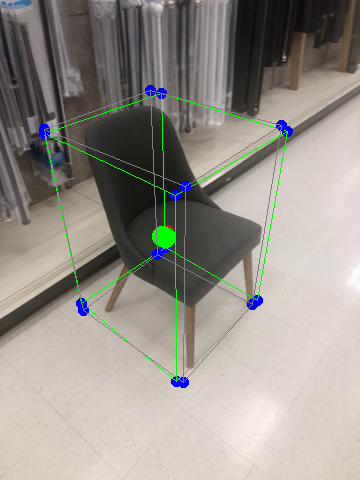

In [26]:
scale = zsp.get_smooth_scale_factor(points_3d_query, points3d_scaled, query_intrinsics, 2)
for i in range(0,3):
    obj_radius = zsp.get_dist_from_plane(plane_normal_query, plane_center_query, points3d_scaled[0])
    points3d_scaled = zsp.snap_to_plane(zsp.scale_3d_bbox(points3d_scaled, scale), plane_normal_query, plane_center_query, center_ray, obj_radius = obj_radius*scale)
#    points3d_scaled = snap_to_plane_px(scale_3d_bbox(points_3d_result_centered, scale), plane_normal_query, plane_center_query, plane_normal_result, plane_center_result, obj_radius = obj_radius*scale)
    scale = zsp.get_smooth_scale_factor(points_3d_query, points3d_scaled, query_intrinsics, 2)
    print(i, zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled)))
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled))
query_im=Image.open(info_df.iloc[idx]["filepath_full"])
points2d_px_result = zsp.project_3d_to_2d(points3d_scaled, query_intrinsics)
points2d_px_query = zsp.project_3d_to_2d(points_3d_query, query_intrinsics)
zsp.draw_bbox(query_im,points2d_px_result)
zsp.draw_bbox(query_im,points2d_px_query, line_color=(128,128,128))

In [27]:
points3d_df = build_df(points_3d_query, "query")
#points3d_df = points3d_df.append(build_df(points_3d_result, "result"))
points3d_df = points3d_df.append(build_df(points3d_scaled, "points3d_scaled"))
fig = px.scatter_3d(points3d_df, x="x", y="y", z="z", color="name")
fig.show()